# Download libraries

In [6]:
%pip install -U ultralytics
%pip install clearml
%pip install opencv-python

   ---------------------------------------- 0.0/677.8 kB ? eta -:--:--
   - -------------------------------------- 30.7/677.8 kB 1.3 MB/s eta 0:00:01
   ----- ---------------------------------- 92.2/677.8 kB 1.1 MB/s eta 0:00:01
   --------------- ------------------------ 256.0/677.8 kB 2.0 MB/s eta 0:00:01
   ------------------------------------ --- 624.6/677.8 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 677.8/677.8 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.234
    Uninstalling ultralytics-8.0.234:
      Successfully uninstalled ultralytics-8.0.234
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=YJ1059TFADHQJZKPNEDC
%env CLEARML_API_SECRET_KEY=h0Hp613a25CwAzmUVxxBLGgxHdMkdBxECVdd5HactPKpMu0Ubs

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=YJ1059TFADHQJZKPNEDC
env: CLEARML_API_SECRET_KEY=h0Hp613a25CwAzmUVxxBLGgxHdMkdBxECVdd5HactPKpMu0Ubs


In [8]:
%pip install supervision inference opencv-python

# Training Data Processing

In [4]:
import pandas as pd
import os
import shutil
import cv2
import glob
import zipfile
import requests
import matplotlib.pyplot as plt
import random


In [5]:

# Đường dẫn đến tệp CSV chứa thông tin chú thích
csv_file_path = 'D:/Drowsiness_Detection/drowsiness_dataset/annotions/_annotations_train.csv'

# Đọc tệp CSV vào dataframe
annotations_df = pd.read_csv(csv_file_path)

# Đường dẫn đến thư mục chứa dữ liệu đã chuẩn bị theo định dạng YOLO
output_folder = 'D:/Drowsiness_Detection/drowsiness_dataset/train/labels'
os.makedirs(output_folder, exist_ok=True)

# Duyệt qua từng dòng trong dataframe và tạo nội dung cho file YOLO cho mỗi ảnh
for index, row in annotations_df.iterrows():
    width = row['width']
    height = row['height']
    
    # Chuyển đổi class_id thành số nguyên (1 cho 'awake' và 0 cho 'drowsy')
    class_id = 1 if row['class'] == 'awake' else 0
    
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    # Chuyển đổi tọa độ bbox thành tọa độ trung tâm và chiều rộng, chiều cao
    center_x = (xmin + xmax) / (2 * width)
    center_y = (ymin + ymax) / (2 * height)
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    # Chuyển đổi tọa độ bbox thành tọa độ trung tâm và chiều rộng, chiều cao
    center_x = (xmin + xmax) / (2 * width)
    center_y = (ymin + ymax) / (2 * height)
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    # Tạo nội dung cho file YOLO, bao gồm class_id và các thông số bbox
    yolo_line = f"{class_id} {center_x} {center_y} {bbox_width} {bbox_height}"

    # Lưu nội dung vào file YOLO
    yolo_file_path = os.path.join(output_folder, f"{row['filename'].replace('.jpg', '.txt')}")
    with open(yolo_file_path, 'w') as yolo_file:
        yolo_file.write(yolo_line + '\n')

In [49]:
"""
Script to remove images without objects from the validation set.
"""
TXT_ROOT = os.path.join('D:/Drowsiness_Detection/drowsiness_dataset/valid/labels')
IMG_ROOT = os.path.join('D:/Drowsiness_Detection/drowsiness_dataset/valid/images')

all_txt_files = os.listdir(TXT_ROOT)

zero_counter = 0
txt_without_obj = []
for i, file_name in enumerate(all_txt_files):
    file_path = os.path.join(TXT_ROOT, file_name)
    with open(file_path, 'r') as f:
        lines = f.readlines()
        if len(lines) == 0:
            zero_counter += 1
            txt_without_obj.append(file_name.split('.txt')[0])
    f.close()

all_img_files = os.listdir(IMG_ROOT)
zero_img_counter = 0
for i, file_name in enumerate(all_img_files):
    file_path = os.path.join(IMG_ROOT, file_name)
    if '.'.join(file_name.split('.')[:-1]) in txt_without_obj:
        zero_img_counter += 1
        # image = cv2.imread(os.path.join(IMG_ROOT, file_name))
        # cv2.imshow('Image', image)
        # cv2.waitKey(0)
        os.remove(os.path.join(IMG_ROOT, file_name))
        os.remove(os.path.join(TXT_ROOT, '.'.join(file_name.split('.')[:-1])+'.txt'))

print(zero_img_counter)

0


In [50]:

# Đường dẫn đến tệp CSV chứa thông tin chú thích
csv_file_path = 'D:/Drowsiness_Detection/drowsiness_dataset/annotions/_annotations_val.csv'

# Đọc tệp CSV vào dataframe
annotations_df = pd.read_csv(csv_file_path)

# Đường dẫn đến thư mục chứa dữ liệu đã chuẩn bị theo định dạng YOLO
output_folder = 'D:/Drowsiness_Detection/drowsiness_dataset/valid/labels'
os.makedirs(output_folder, exist_ok=True)

# Duyệt qua từng dòng trong dataframe và tạo nội dung cho file YOLO cho mỗi ảnh
for index, row in annotations_df.iterrows():
    width = row['width']
    height = row['height']
    
    # Chuyển đổi class_id thành số nguyên (1 cho 'awake' và 0 cho 'drowsy')
    class_id = 1 if row['class'] == 'awake' else 0
    
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    # Chuyển đổi tọa độ bbox thành tọa độ trung tâm và chiều rộng, chiều cao
    center_x = (xmin + xmax) / (2 * width)
    center_y = (ymin + ymax) / (2 * height)
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    # Chuyển đổi tọa độ bbox thành tọa độ trung tâm và chiều rộng, chiều cao
    center_x = (xmin + xmax) / (2 * width)
    center_y = (ymin + ymax) / (2 * height)
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    # Tạo nội dung cho file YOLO, bao gồm class_id và các thông số bbox
    yolo_line = f"{class_id} {center_x} {center_y} {bbox_width} {bbox_height}"

    # Lưu nội dung vào file YOLO
    yolo_file_path = os.path.join(output_folder, f"{row['filename'].replace('.jpg', '.txt')}")
    with open(yolo_file_path, 'w') as yolo_file:
        yolo_file.write(yolo_line + '\n')

# Visualize Images from the Dataset

In [6]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [8]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))
                
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [9]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))
    
    all_images.sort()

    num_images = len(all_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

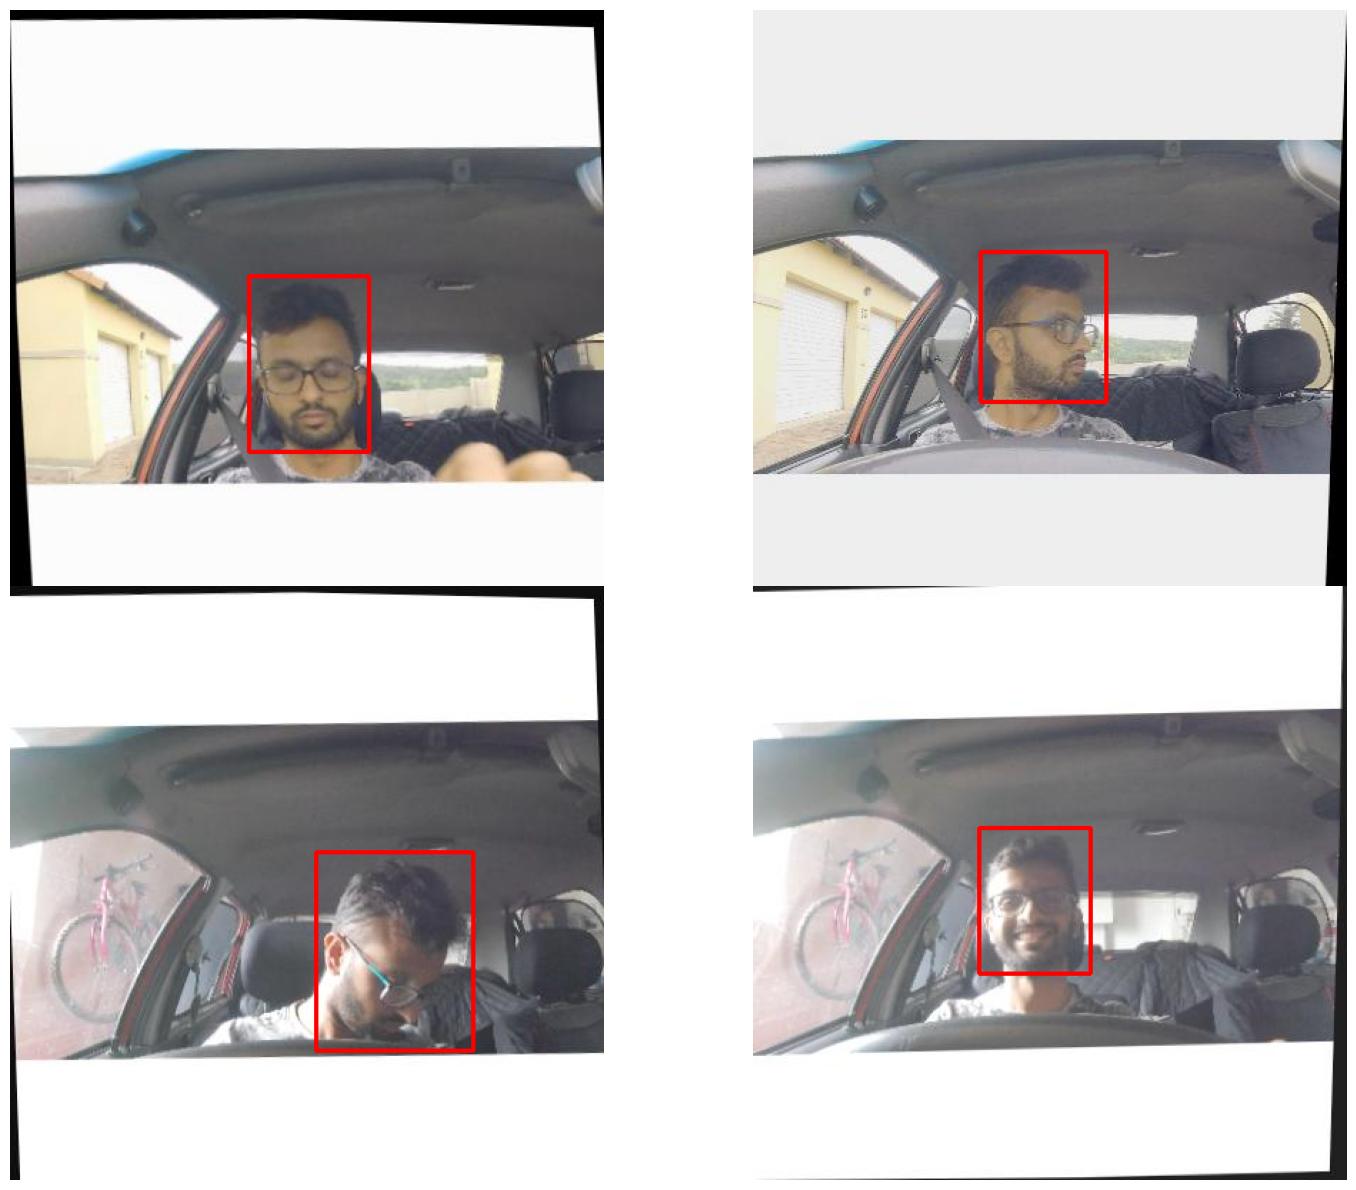

In [10]:
# Visualize a few training images.
plot(
    image_paths='D:/Drowsiness_Detection/drowsiness_dataset/train/images', 
    label_paths='D:/Drowsiness_Detection/drowsiness_dataset/train/labels',
    num_samples=4,
)

# Dataset YAML File

In [95]:
%%writefile data.yaml
path: 'D:/Drowsiness_Detection/drowsiness_dataset'
train: 'D:/Drowsiness_Detection/drowsiness_dataset/train/images'
val: 'D:/Drowsiness_Detection/drowsiness_dataset/valid/images'

# class names
names: 
  0: 'drowsy'
  1: 'awake'

Overwriting data.yaml


# YOLOv8 Nano Training

In [11]:
EPOCHS = 10
!yolo task=detect mode=train model=yolov8n.pt imgsz=416 data=data.yaml epochs={EPOCHS} batch=16 name=yolov8n_v8_50e


  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  1%|          | 72.0k/6.23M [00:00<00:18, 355kB/s]
  3%|▎         | 216k/6.23M [00:00<00:08, 771kB/s] 
  5%|▍         | 312k/6.23M [00:00<00:07, 819kB/s]
  6%|▋         | 408k/6.23M [00:00<00:07, 862kB/s]
  8%|▊         | 504k/6.23M [00:00<00:06, 885kB/s]
  9%|▉         | 600k/6.23M [00:00<00:06, 914kB/s]
 11%|█         | 712k/6.23M [00:00<00:06, 944kB/s]
 13%|█▎        | 824k/6.23M [00:00<00:05, 979kB/s]
 15%|█▍        | 928k/6.23M [00:01<00:06, 895kB/s]
 16%|█▌        | 1.00M/6.23M [00:01<00:06, 905kB/s]
 18%|█▊        | 1.09M/6.23M [00:01<00:06, 849kB/s]
 19%|█▉        | 1.18M/6.23M [00:01<00:06, 821kB/s]
 20%|██        | 1.27M/6.23M [00:01<00:06, 841kB/s]
 22%|██▏       | 1.35M/6.23M [00:01<00:06, 791kB/s]
 23%|██▎       | 1.43M/6.23M [00:01<00:06, 735kB/s]
 24%|██▍       | 1.51M/6.23M [00:01<00:06, 731kB/s]
 25%|██▌       | 1.59M/6.23M [00:02<00:07, 678kB/s]
 27%|██▋       | 1.66M/6.23M [00:02<00:07, 684kB/s]
 28%|██▊       | 1.73M/6.2


Ultralytics YOLOv8.0.231 🚀 Python-3.11.7 torch-2.1.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=10, time=None, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

# Evaluation on Validation Images

In [12]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e2/weights/best.pt name=yolov8n_eval data=data.yaml

Ultralytics YOLOv8.0.231 🚀 Python-3.11.7 torch-2.1.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
                   all        103        103      0.865      0.935      0.969      0.847
                drowsy        103         44      0.923      0.886       0.96      0.839
                 awake        103         59      0.807      0.983      0.977      0.855
Speed: 0.8ms preprocess, 43.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\yolov8n_eval3
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning D:\Drowsiness_Detection\drowsiness_dataset\valid\labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
val: Scanning D:\Drowsiness_Detection\drowsiness_dataset\valid\labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:00<00:04,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  29%|██▊       | 2/7 [00:01<00:04,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  43%|████▎     | 3/7 [00:02<00:03,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  57%|█████▋    | 4/7 [00:03<00:02,  1.12it/s]
        

# Inference on Validation Images

In [13]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8n_v8_50e2/weights/best.pt \
source=D:/Drowsiness_Detection/drowsiness_dataset/valid/images \
imgsz=416 \
name=yolov8n_v8_50e_infer416 \
show_labels=True


Ultralytics YOLOv8.0.231 🚀 Python-3.11.7 torch-2.1.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

image 1/103 D:\Drowsiness_Detection\drowsiness_dataset\valid\images\GOPR0492_MP4-105_jpg.rf.d60d9a06c0a43da198d22b4e1463f3d6.jpg: 416x416 1 drowsy, 58.3ms
image 2/103 D:\Drowsiness_Detection\drowsiness_dataset\valid\images\GOPR0492_MP4-108_jpg.rf.cd3906c5aa7fddfa0dc4d050f72ce228.jpg: 416x416 1 awake, 42.8ms
image 3/103 D:\Drowsiness_Detection\drowsiness_dataset\valid\images\GOPR0492_MP4-113_jpg.rf.e59821fca621f38a6d3e4eadbba8c207.jpg: 416x416 1 awake, 42.1ms
image 4/103 D:\Drowsiness_Detection\drowsiness_dataset\valid\images\GOPR0492_MP4-114_jpg.rf.55a6dec9076f751f02f7899636250867.jpg: 416x416 1 awake, 44.2ms
image 5/103 D:\Drowsiness_Detection\drowsiness_dataset\valid\images\GOPR0492_MP4-122_jpg.rf.5b8d6290eea7c4b57079871f5059860a.jpg: 416x416 1 awake, 38.2ms
image 6/103 D:\Drowsiness_Detection\drowsiness

# Visualize Validation Results

In [14]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

In [15]:
visualize('runs/detect/yolov8n_v8_50e_infer4162/')

# Test Data Processing

In [96]:

# Đường dẫn đến tệp CSV chứa thông tin chú thích
csv_file_path = 'D:/Drowsiness_Detection/drowsiness_dataset/annotions/_annotations_test.csv'

# Đọc tệp CSV vào dataframe
annotations_df = pd.read_csv(csv_file_path)

# Đường dẫn đến thư mục chứa dữ liệu đã chuẩn bị theo định dạng YOLO
output_folder = 'D:/Drowsiness_Detection/drowsiness_dataset/test/labels'
os.makedirs(output_folder, exist_ok=True)

# Duyệt qua từng dòng trong dataframe và tạo nội dung cho file YOLO cho mỗi ảnh
for index, row in annotations_df.iterrows():
    width = row['width']
    height = row['height']
    
    # Chuyển đổi class_id thành số nguyên (1 cho 'awake' và 0 cho 'drowsy')
    class_id = 1 if row['class'] == 'awake' else 0
    
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    # Chuyển đổi tọa độ bbox thành tọa độ trung tâm và chiều rộng, chiều cao
    center_x = (xmin + xmax) / (2 * width)
    center_y = (ymin + ymax) / (2 * height)
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    # Chuyển đổi tọa độ bbox thành tọa độ trung tâm và chiều rộng, chiều cao
    center_x = (xmin + xmax) / (2 * width)
    center_y = (ymin + ymax) / (2 * height)
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    # Tạo nội dung cho file YOLO, bao gồm class_id và các thông số bbox
    yolo_line = f"{class_id} {center_x} {center_y} {bbox_width} {bbox_height}"

    # Lưu nội dung vào file YOLO
    yolo_file_path = os.path.join(output_folder, f"{row['filename'].replace('.jpg', '.txt')}")
    with open(yolo_file_path, 'w') as yolo_file:
        yolo_file.write(yolo_line + '\n')

# Inference on Test Images

In [98]:
!yolo task=detect mode=predict \
  model=runs/detect/yolov8n_v8_50e/weights/best.pt \
  source=D:/Drowsiness_Detection/drowsiness_dataset/test/images\
  name=yolov8n_test_predictions \
  imgsz=416 \
  conf=0.5 \
  save_txt=True


Ultralytics YOLOv8.0.230 🚀 Python-3.11.7 torch-2.1.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

image 1/71 D:\Drowsiness_Detection\drowsiness_dataset\test\images\GOPR0492_MP4-100_jpg.rf.b8becff32c2326c70edb8d719f0239cb.jpg: 416x416 1 drowsy, 52.7ms
image 2/71 D:\Drowsiness_Detection\drowsiness_dataset\test\images\GOPR0492_MP4-109_jpg.rf.d5dc228e2758dbf1905b1885faedcb88.jpg: 416x416 1 awake, 40.1ms
image 3/71 D:\Drowsiness_Detection\drowsiness_dataset\test\images\GOPR0492_MP4-117_jpg.rf.0db739d10912e81f52f6c7f2454b1276.jpg: 416x416 1 drowsy, 40.2ms
image 4/71 D:\Drowsiness_Detection\drowsiness_dataset\test\images\GOPR0492_MP4-121_jpg.rf.cab81895fd844e5a742213209ce53a29.jpg: 416x416 1 awake, 40.8ms
image 5/71 D:\Drowsiness_Detection\drowsiness_dataset\test\images\GOPR0492_MP4-126_jpg.rf.f31e7d36af507bb7f9b2980de25378ec.jpg: 416x416 1 awake, 47.2ms
image 6/71 D:\Drowsiness_Detection\drowsiness_dataset\t

# Visualize Test Results

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

In [99]:
visualize('runs/detect/yolov8n_test_predictions/')

# Test by video

In [1]:
!yolo task=detect mode=predict model="D:/Drowsiness_Detection/runs/detect/yolov8n_v8_50e/weights/best.pt" source="D:/Drowsiness_Detection/driver-sleeps-for-a-full-minute-while-driving.mp4"


Ultralytics YOLOv8.0.230 🚀 Python-3.11.7 torch-2.1.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

video 1/1 (1/1477) D:\Drowsiness_Detection\driver-sleeps-for-a-full-minute-while-driving.mp4: 256x416 (no detections), 55.5ms
video 1/1 (2/1477) D:\Drowsiness_Detection\driver-sleeps-for-a-full-minute-while-driving.mp4: 256x416 (no detections), 26.6ms
video 1/1 (3/1477) D:\Drowsiness_Detection\driver-sleeps-for-a-full-minute-while-driving.mp4: 256x416 (no detections), 27.4ms
video 1/1 (4/1477) D:\Drowsiness_Detection\driver-sleeps-for-a-full-minute-while-driving.mp4: 256x416 (no detections), 26.5ms
video 1/1 (5/1477) D:\Drowsiness_Detection\driver-sleeps-for-a-full-minute-while-driving.mp4: 256x416 (no detections), 26.0ms
video 1/1 (6/1477) D:\Drowsiness_Detection\driver-sleeps-for-a-full-minute-while-driving.mp4: 256x416 (no detections), 25.0ms
video 1/1 (7/1477) D:\Drowsiness_Detection\driver-sleeps-for-

# Test by Webcam

In [4]:
!git clone https://github.com/ultralytics/yolov5.git


Cloning into 'yolov5'...


In [9]:
%pip install customtkinter

In [10]:
%pip install python-vlc


Note: you may need to restart the kernel to use updated packages.


In [2]:
import tkinter as tk
import customtkinter as ctk
import torch
import numpy as np
import cv2
from PIL import Image, ImageTk
import vlc
import random
import threading

app = tk.Tk()
app.geometry("600x600")
app.title("Drowsy Boi 4.0")
ctk.set_appearance_mode("dark")

vidFrame = tk.Frame(height=480, width=600)
vidFrame.pack()
vid = ctk.CTkLabel(vidFrame)
vid.pack()

counter = 0
counterLabel = ctk.CTkLabel(app, text=counter, height=40, width=120, font=("Arial", 20), text_color="white",
                             fg_color="teal")
counterLabel.pack(pady=10)

def reset_counter():
    global counter
    counter = 0
resetButton = ctk.CTkButton(app, text="Reset Counter", command=reset_counter, height=40, width=120, font=("Arial", 20),
                             text_color="white", fg_color="teal")
resetButton.pack()

model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp9/weights/last.pt', force_reload=True)
cap = cv2.VideoCapture(0)  # Điều chỉnh chỉ số chụp video nếu cần

def play_random_audio():
    file_choice = random.choice([1, 2, 3])
    p = vlc.MediaPlayer(f"file:///{file_choice}.wav")
    p.play()

def detect():
    global counter
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = model(frame)
    img = np.squeeze(results.render())

    if len(results.xywh[0]) > 0:
        dconf = results.xywh[0][0][4]
        dclass = results.xywh[0][0][5]

        if dconf.item() > 0.85 and dclass.item() == 1.0:
            threading.Thread(target=play_random_audio).start()
            counter += 1

    imgarr = Image.fromarray(img)
    imgtk = ImageTk.PhotoImage(imgarr)
    vid.imgtk = imgtk
    vid.configure(image=imgtk)
    vid.after(10, detect)
    counterLabel.configure(text=counter)

detect()

# Hàm xử lý sự kiện đóng cửa sổ
def on_close():
    if tk.messagebox.askokcancel("Quit", "Do you want to quit?"):
        app.destroy()

# Ràng buộc sự kiện đóng cửa sổ vào hàm on_close
app.protocol("WM_DELETE_WINDOW", on_close)

app.mainloop()


Downloading: "https://github.com/ultralytics/ultralytics/zipball/main" to C:\Users\ASUS/.cache\torch\hub\main.zip


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ASUS/.cache\\torch\\hub\\ultralytics_ultralytics_main\\hubconf.py'

In [13]:
from ultralytics import YOLO 
import cv2  

model = YOLO("D:/Drowsiness_Detection/runs/detect/yolov8n_v8_50e2/weights/best.pt")
results = model.predict(source="0", show=True)

# Print results with confidence scores
for det in results.xyxy[0]:
    class_id, confidence, x_min, y_min, x_max, y_max = det.tolist()
    print(f"Class ID: {class_id}, Confidence: {confidence:.2f}, BBox: ({x_min}, {y_min}, {x_max}, {y_max})")


AttributeError: module 'torch' has no attribute '_utils'

In [2]:
%pip install pydub

Note: you may need to restart the kernel to use updated packages.


In [5]:
from ultralytics import YOLO 
import cv2 
from pydub import AudioSegment
from pydub.playback import play

model = YOLO("D:/Drowsiness_Detection/runs/detect/yolov8n_v8_50e2/weights/best.pt")
results = model.predict(source="0", show=True)
print(results)

# Bổ sung sau lệnh print(results)
for result in results.xyxy[0]:
    label = int(result[-1])
    if label == 1:  # Nhãn của drowsy
        # Chơi âm thanh cảnh báo
        alert_sound = AudioSegment.from_file("nhac-chuong-tieng-coi-canh-bao.wav", format="wav")
        play(alert_sound)


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttributeError: module 'torch' has no attribute '_utils'